In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from scipy import integrate, optimize, stats, special
from scipy.optimize import minimize
import seaborn as sns
import pandas as pd


plt.rc('text', usetex = True)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
font_size = 14
plt.rcParams['font.size'] = font_size
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

Load data from the text file

In [2]:
datafile = open('./../data/SCPUnion2.1_mu_vs_z.txt','r')
SCP_data = pd.read_table(datafile,comment='#',
                        names=['SN name','Redshift','Distance modulus',
                                   'Distance modulus error','P low mass'])
print(SCP_data)


    SN name  Redshift  Distance modulus  Distance modulus error  P low mass
0    1993ah  0.028488         35.346583                0.223906    0.128419
1    1993ag  0.050043         36.682368                0.166829    0.128419
2     1993o  0.052926         36.817691                0.155756    0.128419
3     1993b  0.070086         37.446737                0.158467    0.128419
4    1992bs  0.062668         37.483409                0.156099    0.128419
..      ...       ...               ...                     ...         ...
575   D-000  1.017000         44.293971                0.171046    0.000015
576   D-006  1.315000         44.971358                0.187509    0.551672
577   P-009  0.821000         43.640939                0.194014    0.551672
578   R-012  1.215000         45.246521                0.560317    0.000148
579   Z-005  0.623000         42.514524                0.241428    0.551672

[580 rows x 5 columns]


Some preliminary plots to visualize the data. 

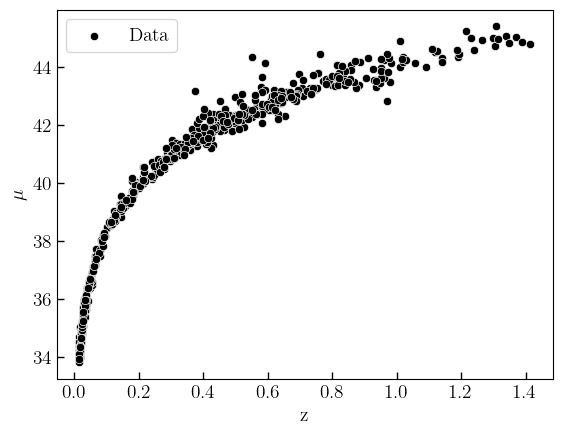

In [3]:
sns.scatterplot(x=SCP_data['Redshift'],y=SCP_data['Distance modulus'],label='Data',color='black');
plt.xlabel('z');
plt.ylabel(f'$\mu$');

Number of supernovae with z < 0.5: 412
Percentage of total data: 71.0%


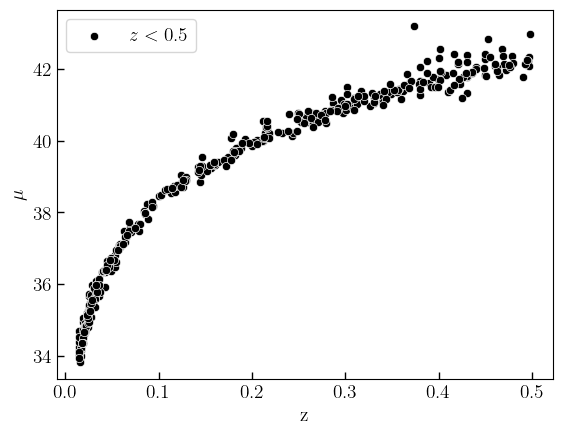

In [4]:
df_lowz = SCP_data[SCP_data['Redshift'] < 0.5].copy()

print(f"Number of supernovae with z < 0.5: {len(df_lowz)}")
print(f"Percentage of total data: {len(df_lowz)/len(SCP_data)*100:.1f}%")

# Low-z data scatter plot
sns.scatterplot(x=df_lowz['Redshift'],y=df_lowz['Distance modulus'],label=f'$z < 0.5$',color='black');
plt.xlabel('z');
plt.ylabel(f'$\mu$');

In [5]:
c = 299792.458  # Km/s
def distance_modulus_model(z, H0, q0):
    """
    d_L = c/H_0 (z+1/2(1-q_0)z^2)
    mu = 5 log(d_l)+25
    
    input: z, H0, q0
    output: mu
    
    """
    dL = (c / H0) * (z + 0.5 * (1 - q0) * z**2)
    
    mu = 5 * np.log10(dL) + 25
    return mu

In [32]:
def log_inverse_gamma(x, alpha, beta):
    """
    f(x;alpha, beta) = (\beta^\alpha/gamma_fxn(\alpha))(1/x)^{\alpha+1}exp{\beta/x}
    """
    return (alpha * np.log(beta) - special.gammaln(alpha) 
            - (alpha + 1) * np.log(x) - beta/x)

def log_prior(params):
    """
    Prior distributions for parameters [H0, q0, sigma]
    """
    H0, q0, sigma2 = params
    
    # Uniform priors for H0 and q0
    if not (50 < H0 < 100):
        return -np.inf
    if not (-2 < q0 < 2):
        return -np.inf
    if sigma2 <= 0:
        return -np.inf
    
    # Inverse Gamma prior for sigma^2 -- intrinsic scatter
    alpha = 2   
    beta = 0.1  
    log_prior_sigma2 = log_inverse_gamma(sigma2, alpha, beta)
    
    return log_prior_sigma2
    

In [33]:
def log_likelihood(params, z_data, mu_data, mu_err_data):
    """
    Gaussian log-likelihood with measurement errors and intrinsic scatter
    Uses data weights proportional to measurement errors
    """
    H0, q0, sigma2 = params
    #sigma = np.sqrt(sigma2)
    
    mu_model = distance_modulus_model(z_data, H0, q0)
    
    # Total variance = measurement error^2 + intrinsic scatter^2
    total_variance = mu_err_data**2 + sigma2
    
    # Gaussian log-likelihood with weights as measurement error
    logL = -0.5 * np.sum(
        (mu_data - mu_model)**2 / total_variance + 
        np.log(2 * np.pi * total_variance)
    )
    
    return logL

def log_posterior(params, z_data, mu_data, mu_err_data):
    """
    Total log posterior = log_prior + log_likelihood
    """
    lp = log_prior(params)
    
    ll = log_likelihood(params, z_data, mu_data, mu_err_data)
    return lp + ll

def neg_log_posterior(params):
    return -log_posterior(params, z_data, mu_data, mu_err_data)

In [34]:
z_data = df_lowz['Redshift'].values
mu_data = df_lowz['Distance modulus'].values
mu_err_data = df_lowz['Distance modulus error'].values

Now we can find MAP Estimate:

In [35]:
initial_guess = [70, -0.5, 0.04] # H0,q0, sigma

In [36]:
print("Finding MAP estimate:")
result = minimize(neg_log_posterior, initial_guess, method='Nelder-Mead')
print("MAP complete")

Finding MAP estimate:
MAP complete


In [38]:
if result.success:
    map_estimate = result.x
    print("MAP Estimation success")
    print(f"H$_o$ = {map_estimate[0]:.2f} km/s/Mpc")
    print(f"q$_o$ = {map_estimate[1]:.3f}")
    print(f"σ$^2$ = {map_estimate[2]:.3f} ")
else:
    print("MAP Estimation failed")
    map_estimate = initial_guess

MAP Estimation success
H$_o$ = 69.71 km/s/Mpc
q$_o$ = -0.415
σ$^2$ = 0.007 


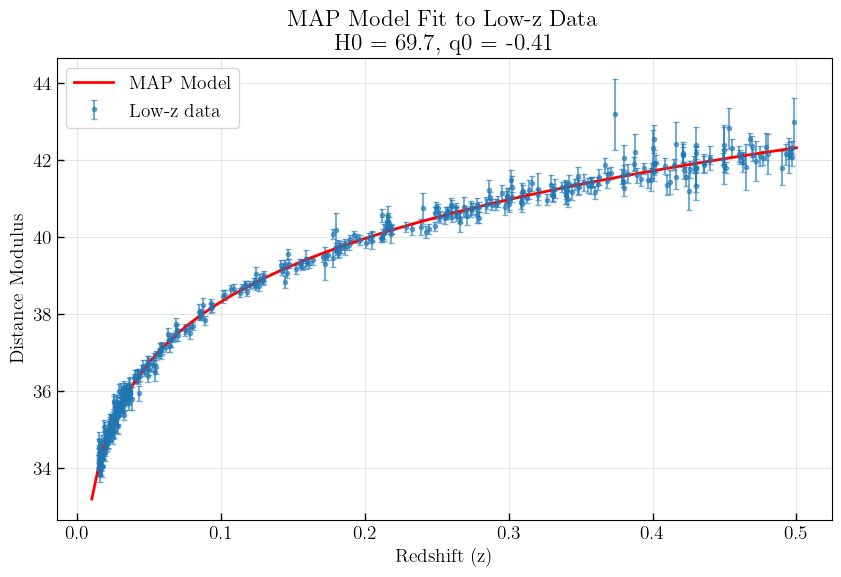

In [39]:
plt.figure(figsize=(10, 6))
z_plot = np.linspace(0.01, 0.5, 100)
mu_plot = distance_modulus_model(z_plot, map_estimate[0], map_estimate[1])

plt.errorbar(z_data, mu_data, yerr=mu_err_data, fmt='o', alpha=0.6, 
             label='Low-z data', markersize=3, capsize=2)
plt.plot(z_plot, mu_plot, 'r-', linewidth=2, label='MAP Model')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus')
plt.title(f'MAP Model Fit to Low-z Data\nH0 = {map_estimate[0]:.1f}, q0 = {map_estimate[1]:.2f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Model fit for complete data

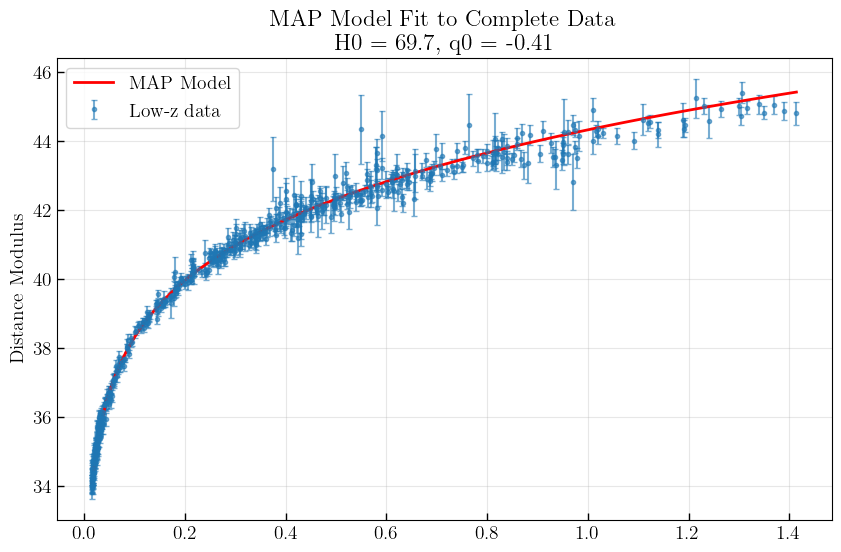

In [40]:
plt.figure(figsize=(10, 6))

z_all = SCP_data['Redshift'].values
mu_all = SCP_data['Distance modulus'].values
mu_err_all = SCP_data['Distance modulus error'].values


z_plot = np.linspace(min(z_all), max(z_all), 100)  
mu_plot = distance_modulus_model(z_plot, map_estimate[0], map_estimate[1])  

plt.errorbar(z_all, mu_all, yerr=mu_err_all, fmt='o', alpha=0.6, 
             label='Low-z data', markersize=3, capsize=2)
plt.plot(z_plot, mu_plot, 'r-', linewidth=2, label='MAP Model')  
plt.ylabel('Distance Modulus')
plt.title(f'MAP Model Fit to Complete Data\nH0 = {map_estimate[0]:.1f}, q0 = {map_estimate[1]:.2f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

MCMC Sampling:

In [41]:
nwalkers = 32
ndim = 3  # H0, q0, sigma2
nsteps = 2000
burnin = 500

In [42]:
initial_pos = map_estimate + 1e-4 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, 
    args=(z_data, mu_data, mu_err_data)
)


In [43]:
print("Running MCMC.....")
sampler.run_mcmc(initial_pos, nsteps, progress=True)
samples = sampler.chain[:, burnin:, :].reshape(-1, ndim)
H0_samples, q0_samples, sigma_samples = samples[:, 0], samples[:, 1], samples[:, 2]
print(f"MCMC complete: {len(samples)} posterior samples")

You must install the tqdm library to use progress indicators with emcee


Running MCMC.....
MCMC complete: 48000 posterior samples


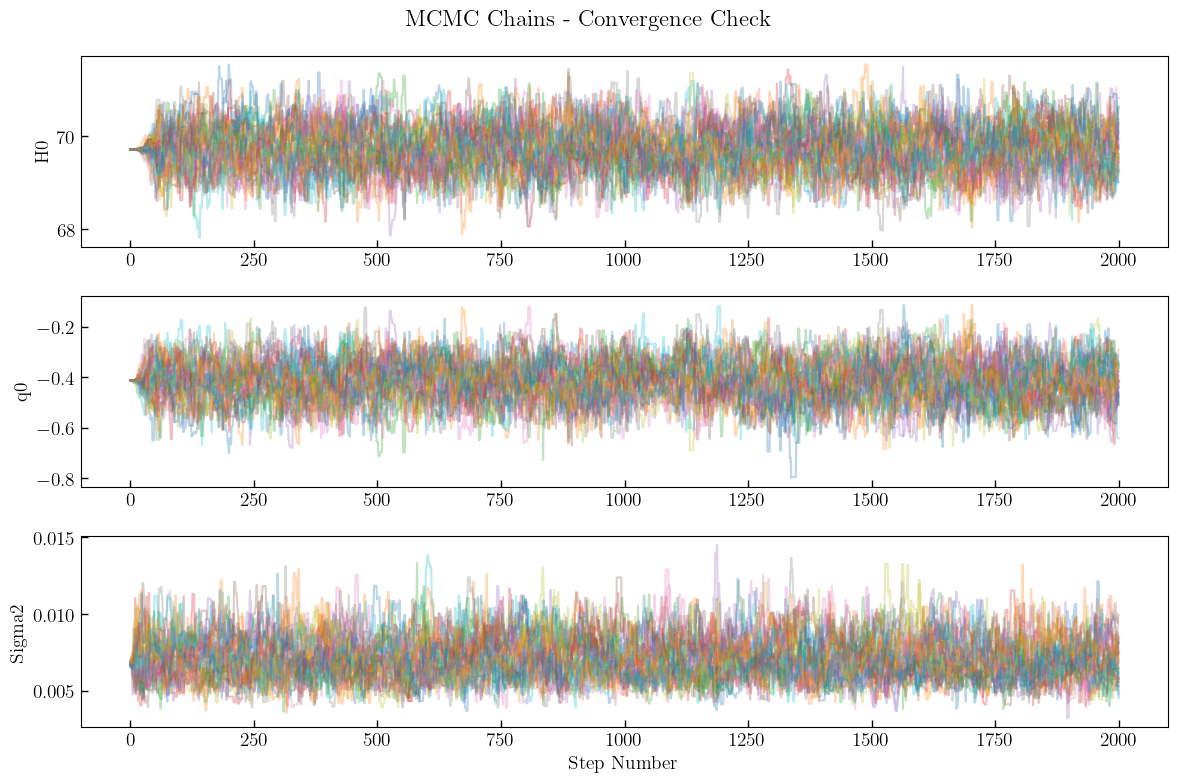

In [44]:
plt.figure(figsize=(12, 8))
for i, param_name in enumerate(['H0', 'q0', 'Sigma2']):
    plt.subplot(3, 1, i+1)
    plt.plot(sampler.chain[:, :, i].T, alpha=0.3)
    plt.ylabel(param_name)
    if i == 2:
        plt.xlabel('Step Number')
plt.suptitle('MCMC Chains - Convergence Check')
plt.tight_layout()
plt.show()

TASK 1 RESULTS
H0 = 69.7 +0.5 -0.5 km/s/Mpc
q0 = -0.416 +0.078 -0.082


<Figure size 1000x800 with 0 Axes>

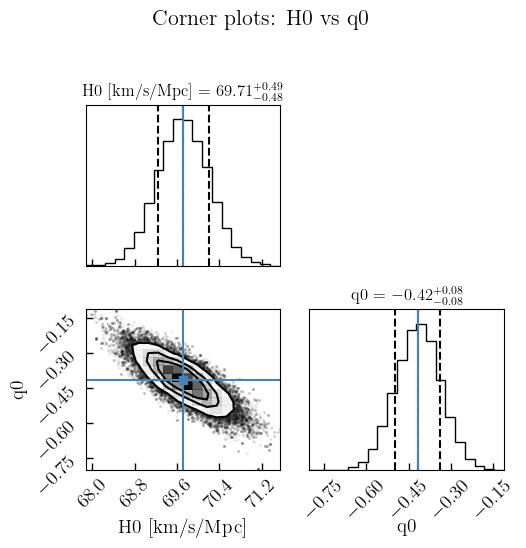

In [45]:
# Calculate summary statistics
H0_median = np.median(H0_samples)
H0_low, H0_high = np.percentile(H0_samples, [16, 84])

q0_median = np.median(q0_samples)
q0_low, q0_high = np.percentile(q0_samples, [16, 84])

sigma_median = np.median(sigma_samples)

print("TASK 1 RESULTS")
print(f"H0 = {H0_median:.1f} +{H0_high-H0_median:.1f} -{H0_median-H0_low:.1f} km/s/Mpc")
print(f"q0 = {q0_median:.3f} +{q0_high-q0_median:.3f} -{q0_median-q0_low:.3f}")
#print(f"Intrinsic scatter variance = {sigma2_median:.3f}")
#print(f"Intrinsic scatter std dev = {sigma_median:.3f}")

# corner plot
plt.figure(figsize=(10, 8))
corner.corner(
    samples[:, :2],  # Only H0 and q0
    labels=['H0 [km/s/Mpc]', 'q0'],
    truths=[H0_median, q0_median],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12}
)
plt.suptitle('Corner plots: H0 vs q0', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Probability that q0 < 0: 100.0%


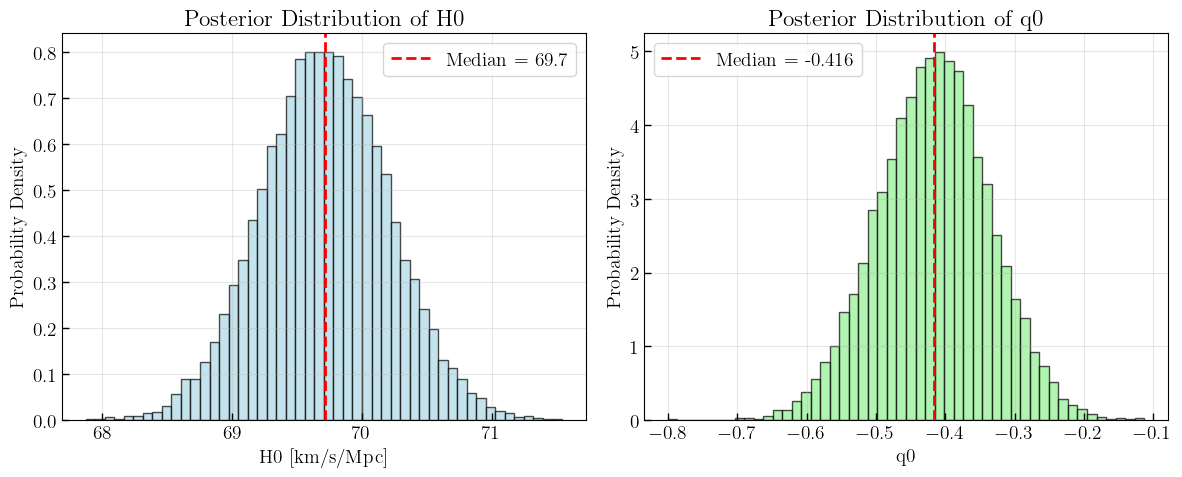

In [46]:
prob_accelerating = np.mean(q0_samples < 0)

print(f"Probability that q0 < 0: {prob_accelerating*100:.1f}%")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# H0 marginal probabilities
ax1.hist(H0_samples, bins=50, density=True, alpha=0.7, color='lightblue', edgecolor='black')
ax1.axvline(H0_median, color='red', linestyle='--', linewidth=2, 
            label=f'Median = {H0_median:.1f}')
ax1.set_xlabel('H0 [km/s/Mpc]')
ax1.set_ylabel('Probability Density')
ax1.set_title('Posterior Distribution of H0')
ax1.legend()
ax1.grid(True, alpha=0.3)

# q0 marginal probabilities
ax2.hist(q0_samples, bins=50, density=True, alpha=0.7, color='lightgreen', edgecolor='black')
ax2.axvline(q0_median, color='red', linestyle='--', linewidth=2, 
            label=f'Median = {q0_median:.3f}')
ax2.set_xlabel('q0')
ax2.set_ylabel('Probability Density')
ax2.set_title('Posterior Distribution of q0')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

/var/folders/0v/fj57h31d0g1br977c9mq8y7c0000gn/T/ipykernel_33063/4027784008.py:100: RuntimeWarning: divide by zero encountered in log10
  return 5 * np.log10(dL) + 25
/Users/gravity/Python_Env/advml/lib/python3.9/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


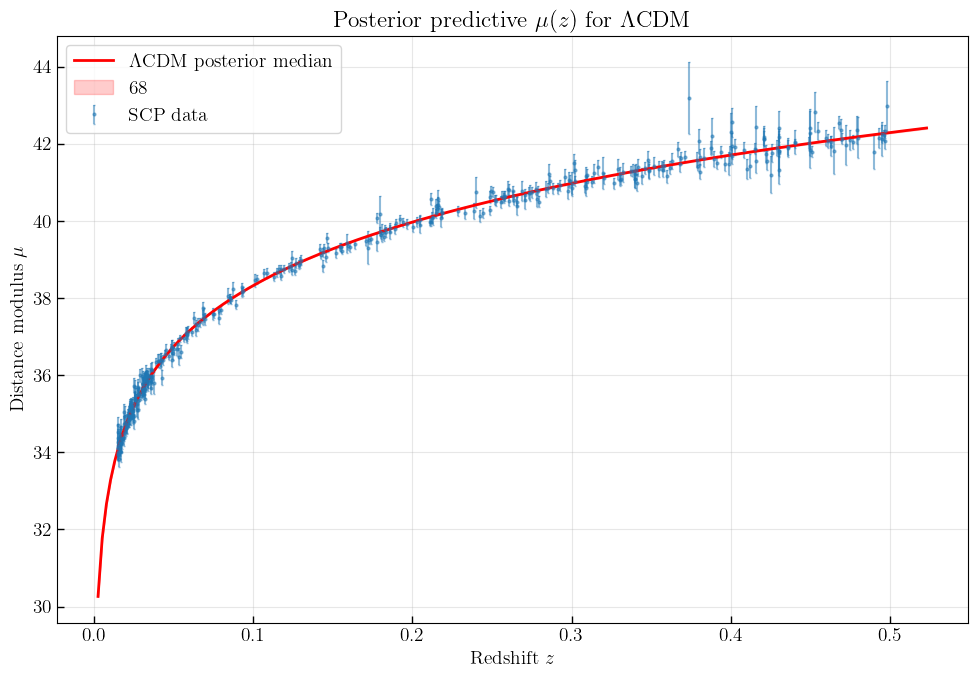

In [136]:
z_grid = np.linspace(0.0, np.max(z_data) * 1.05, 200)
# thin the posterior samples
n_draws = 200
rng = np.random.default_rng(42)  # for reproducibility
idx = rng.choice(Omega_m0_samples.size, size=n_draws, replace=False)
Omega_draws = Omega_m0_samples[idx]

# for each draw, compute μ(z) on the grid
mu_pred_samples = []

for Om in Omega_draws:
    mu_pred = distance_modulus(z_grid, hubble_parameter_lcdm, [Om])
    mu_pred_samples.append(mu_pred)

mu_pred_samples = np.array(mu_pred_samples)   # shape (n_draws, len(z_grid))
mu_pred_median = np.median(mu_pred_samples, axis=0)
mu_pred_low, mu_pred_high = np.percentile(mu_pred_samples, [16, 84], axis=0)
plt.figure(figsize=(10, 7))

# SCP data with error bars
plt.errorbar(
    z_data, mu_data, yerr=mu_err_data,
    fmt='o', ms=2, alpha=0.5, capsize=1,
    label='SCP data'
)

# posterior predictive median
plt.plot(
    z_grid, mu_pred_median,
    'r-', lw=2, label=r'$\Lambda$CDM posterior median'
)

# 68% credible band
plt.fill_between(
    z_grid, mu_pred_low, mu_pred_high,
    color='red', alpha=0.2,
    label=r'68% posterior predictive band'
)

plt.xlabel('Redshift $z$')
plt.ylabel(r'Distance modulus $\mu$')
plt.title(r'Posterior predictive $\mu(z)$ for $\Lambda$CDM')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


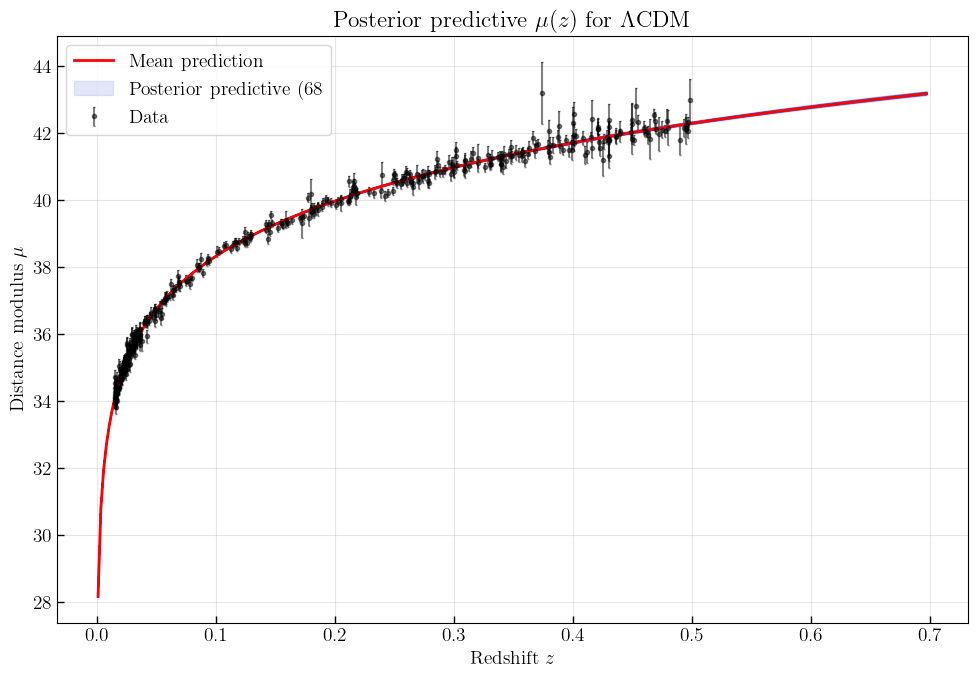

Max half-width of 68% band: 0.022614737666376783


In [139]:
# 1. z grid (extend beyond data if you want to "extrapolate")
z_min = 1e-3
z_max = max(z_data) * 1.4   # or e.g. 1.4 if you want to mimic the reference exactly
z_grid = np.linspace(z_min, z_max, 300)

# 2. Draw posterior samples of Ω_m0
n_draws = 200
rng = np.random.default_rng(42)
idx = rng.choice(Omega_m0_samples.size, size=n_draws, replace=False)
Omega_draws = Omega_m0_samples[idx]

# 3. Compute posterior predictive μ(z) for each draw
mu_pred_all = np.empty((n_draws, z_grid.size))

for i, Om in enumerate(Omega_draws):
    mu_pred_all[i] = distance_modulus(z_grid, hubble_parameter_lcdm, [Om])

# 4. Summary curve: mean or median
mu_mean = np.mean(mu_pred_all, axis=0)
mu_low, mu_high = np.percentile(mu_pred_all, [16, 84], axis=0)  # optional band

plt.figure(figsize=(10, 7))

# Data
plt.errorbar(
    z_data, mu_data, yerr=mu_err_data,
    fmt='o', ms=3, alpha=0.5, capsize=1,
    color='black', label='Data'
)

# Many posterior predictive curves (faint blue)
for i in range(n_draws):
    plt.plot(z_grid, mu_pred_all[i],
             color='royalblue', alpha=0.08, linewidth=1)

# Mean prediction curve in red
plt.plot(z_grid, mu_mean,
         color='red', linewidth=2,
         label='Mean prediction')

# Optional: shaded 68% credible band
plt.fill_between(
    z_grid, mu_low, mu_high,
    color='royalblue', alpha=0.15,
    label='Posterior predictive (68%)'
)

plt.xlabel('Redshift $z$')
plt.ylabel('Distance modulus $\\mu$')
plt.title(r'Posterior predictive $\mu(z)$ for $\Lambda$CDM')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
# after computing mu_low, mu_high:
band_width = np.max(mu_high - mu_low)
print("Max half-width of 68% band:", band_width / 2)


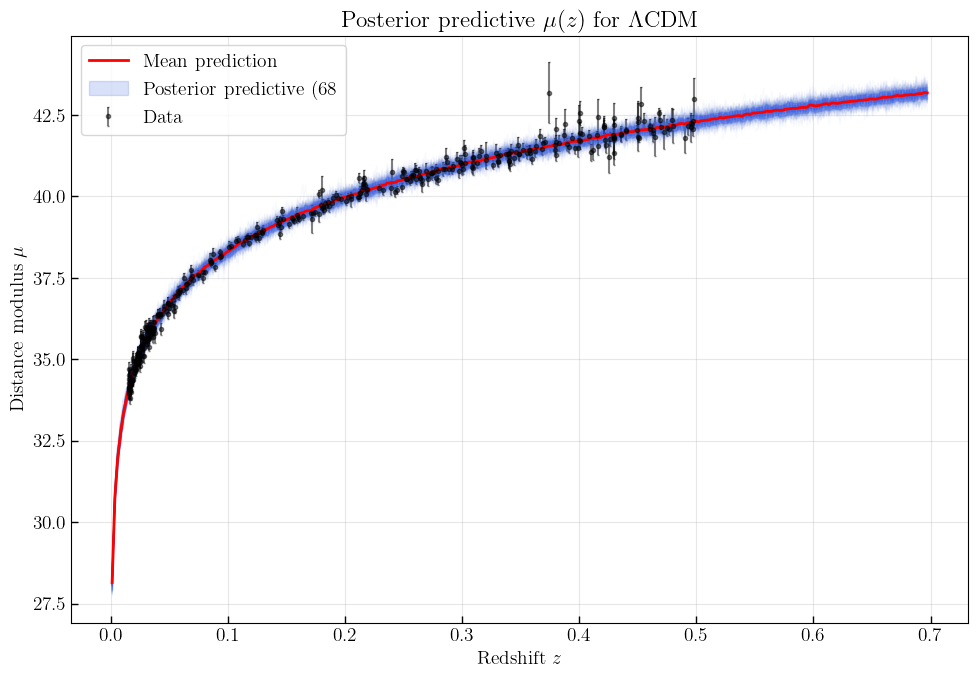

In [142]:
sigma_obs = np.median(mu_err_data)

# posterior predictive including noise
mu_pp_all = mu_pred_all + rng.normal(
    loc=0.0, scale=sigma_obs,
    size=mu_pred_all.shape
)

mu_pp_mean = mu_pp_all.mean(axis=0)
mu_pp_low, mu_pp_high = np.percentile(mu_pp_all, [16, 84], axis=0)
plt.figure(figsize=(10, 7))

plt.errorbar(
    z_data, mu_data, yerr=mu_err_data,
    fmt='o', ms=3, alpha=0.5, capsize=1,
    color='black', label='Data'
)

# Many noisy posterior predictive curves
for i in range(n_draws):
    plt.plot(z_grid, mu_pp_all[i],
             color='royalblue', alpha=0.03, linewidth=1)

# Mean prediction (still red)
plt.plot(z_grid, mu_pp_mean,
         color='red', linewidth=2,
         label='Mean prediction')

# 68% posterior predictive band
plt.fill_between(
    z_grid, mu_pp_low, mu_pp_high,
    color='royalblue', alpha=0.2,
    label='Posterior predictive (68%)'
)

plt.xlabel('Redshift $z$')
plt.ylabel('Distance modulus $\\mu$')
plt.title(r'Posterior predictive $\mu(z)$ for $\Lambda$CDM')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


Comparison with linear model at even low z values

In [47]:
# linear model of H0 extraction, for very low z values
df_very_lowz = SCP_data[SCP_data['Redshift'] < 0.1].copy()
print(f"Number of supernovae with z < 0.1: {len(df_very_lowz)}")


z_vlow = df_very_lowz['Redshift'].values
mu_vlow = df_very_lowz['Distance modulus'].values
mu_err_vlow = df_very_lowz['Distance modulus error'].values
    
    
def distance_modulus_linear(z, H0):
    dL = (c / H0) * z  # dropped second term
    mu = 5 * np.log10(dL) + 25
    return mu
    
def log_posterior_linear(params, z_data, mu_data, mu_err_data):
    H0, sigma2 = params
    if not (50 < H0 < 100) or sigma2 <= 0:
        return -np.inf
        
    mu_model = distance_modulus_linear(z_data, H0)
    total_variance = mu_err_data**2 + sigma2
    logL = -0.5 * np.sum(
        (mu_data - mu_model)**2 / total_variance + 
        np.log(2 * np.pi * total_variance)
    )
        
    log_prior_sigma2 = log_inverse_gamma(sigma2, 2, 0.1)
    return logL + log_prior_sigma2
    

def neg_log_posterior_linear(params):
    return -log_posterior_linear(params, z_vlow, mu_vlow, mu_err_vlow)
initial_linear = [70, 0.04]   
result_linear = minimize(neg_log_posterior_linear, initial_linear, method='Nelder-Mead')
    
if result_linear.success:
    map_linear = result_linear.x
    H0_linear_map = map_linear[0]
    print(f"Linear model MAP: H0 = {H0_linear_map:.2f} km/s/Mpc")
else:
    H0_linear_map = 70
    print("Linear model MAP failed, default H0 = 70")
    
# MCMC for linear model
nwalkers_linear = 16
nsteps_linear = 1000
burnin_linear = 300
    
initial_pos_linear = np.array([H0_linear_map, 0.04]) + 1e-4 * np.random.randn(nwalkers_linear, 2)
    
sampler_linear = emcee.EnsembleSampler(
    nwalkers_linear, 2, log_posterior_linear,
    args=(z_vlow, mu_vlow, mu_err_vlow)
)
    
sampler_linear.run_mcmc(initial_pos_linear, nsteps_linear, progress=False)
samples_linear = sampler_linear.chain[:, burnin_linear:, :].reshape(-1, 2)
H0_linear_samples = samples_linear[:, 0]
    
H0_linear_median = np.median(H0_linear_samples)
H0_linear_low, H0_linear_high = np.percentile(H0_linear_samples, [16, 84])
    
print(f"H₀ from full model (z < 0.5): {H0_median:.1f} +{H0_high-H0_median:.1f} -{H0_median-H0_low:.1f} km/s/Mpc")
print(f"H₀ from linear model (z < 0.1): {H0_linear_median:.1f} +{H0_linear_high-H0_linear_median:.1f} -{H0_linear_median-H0_linear_low:.1f} km/s/Mpc")
print(f"Difference: {abs(H0_median - H0_linear_median):.1f} km/s/Mpc")

Number of supernovae with z < 0.1: 175
Linear model MAP: H0 = 67.93 km/s/Mpc
H₀ from full model (z < 0.5): 69.7 +0.5 -0.5 km/s/Mpc
H₀ from linear model (z < 0.1): 68.0 +0.5 -0.5 km/s/Mpc
Difference: 1.8 km/s/Mpc


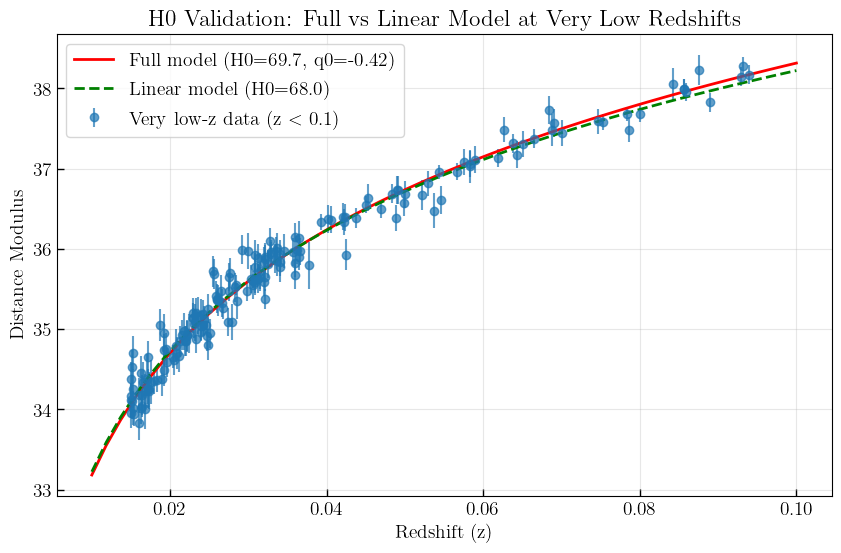

In [48]:
plt.figure(figsize=(10, 6))
plt.errorbar(z_vlow, mu_vlow, yerr=mu_err_vlow, fmt='o', 
                 label=f'Very low-z data (z $<$ 0.1)', alpha=0.7)
    
z_plot = np.linspace(0.01, 0.1, 50)
mu_full = distance_modulus_model(z_plot, H0_median, q0_median)
mu_linear = distance_modulus_linear(z_plot, H0_linear_median)
    
plt.plot(z_plot, mu_full, 'r-', linewidth=2, 
             label=f'Full model (H0={H0_median:.1f}, q0={q0_median:.2f})')
plt.plot(z_plot, mu_linear, 'g--', linewidth=2, 
             label=f'Linear model (H0={H0_linear_median:.1f})')
    
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus')
plt.title('H0 Validation: Full vs Linear Model at Very Low Redshifts')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

TASK 2

In [118]:
from scipy import integrate

c = 299792.458  # km/s

def E_sqrt_z(z, Omega_m0, w):
    """sqrt(E(z)^2) for wCDM, flat universe."""
    Ol0 = 1.0 - Omega_m0
    return np.sqrt(Omega_m0 * (1 + z)**3 + Ol0 * (1 + z)**(3 * (1 + w)))


def dL_Mpc(H0, Omega_m0, w, z):
    """
    Luminosity distance in Mpc:
    dL(z) = (c/H0) (1+z) ∫_0^z dz'/E(z')
    """
    z = np.atleast_1d(z)
    
    def integrand(zp):
        return 1.0 / E_sqrt_z(zp, Omega_m0, w)
    
    I = np.array([
        integrate.quad(integrand, 0.0, zi, epsabs=1e-8, epsrel=1e-8)[0]
        for zi in z
    ])
    return (c / H0) * (1.0 + z) * I


def mu_model(theta, z, model="wCDM"):
    """
    theta:
      LCDM: [H0, Omega_m0]
      wCDM: [H0, Omega_m0, w]
    """
    if model == "LCDM":
        H0, Omega_m0 = theta
        w = -1.0
    else:
        H0, Omega_m0, w = theta
    
    dL = dL_Mpc(H0, Omega_m0, w, z)
    return 5.0 * np.log10(dL) + 25.0


In [119]:
def neg_loglike_theta(theta, z, mu_obs, sigma, model):
    mu_pred = mu_model(theta, z, model=model)
    resid = mu_obs - mu_pred
    chi2 = np.sum((resid / sigma)**2)
    logL = -0.5 * (chi2 + np.sum(np.log(2 * np.pi * sigma**2)))
    return -logL  # we minimise this


def compute_ic(logL_max, k, n):
    AIC = 2 * k - 2 * logL_max
    BIC = k * np.log(n) - 2 * logL_max
    return AIC, BIC


In [120]:
N = len(z_data)

H0_bounds = (30.0, 100.0)
Om_bounds = (0.0, 1.0)
w_bounds  = (-3.0, 1.0)

# ---- LCDM ----
k_lcdm = 2  # H0, Omega_m0
x0_lcdm = np.array([70.0, 0.3])
bounds_lcdm = [H0_bounds, Om_bounds]

res_lcdm = minimize(
    neg_loglike_theta,
    x0_lcdm,
    args=(z_data, mu_data, mu_err_data, "LCDM"),
    bounds=bounds_lcdm,
    method="L-BFGS-B"
)

theta_lcdm = res_lcdm.x
logL_lcdm = -res_lcdm.fun
AIC_lcdm, BIC_lcdm = compute_ic(logL_lcdm, k_lcdm, N)

print("LCDM MLE: H0 = {:.3f}, Ω_m0 = {:.3f}".format(*theta_lcdm))
print("LCDM: logL = {:.3f}, AIC = {:.3f}, BIC = {:.3f}".format(
    logL_lcdm, AIC_lcdm, BIC_lcdm
))


# ---- wCDM ----
k_wcdm = 3  # H0, Omega_m0, w
x0_wcdm = np.array([70.0, 0.3, -1.0])
bounds_wcdm = [H0_bounds, Om_bounds, w_bounds]

res_wcdm = minimize(
    neg_loglike_theta,
    x0_wcdm,
    args=(z_data, mu_data, mu_err_data, "wCDM"),
    bounds=bounds_wcdm,
    method="L-BFGS-B"
)

theta_wcdm = res_wcdm.x
logL_wcdm = -res_wcdm.fun
AIC_wcdm, BIC_wcdm = compute_ic(logL_wcdm, k_wcdm, N)

print("wCDM MLE: H0 = {:.3f}, Ω_m0 = {:.3f}, w = {:.3f}".format(*theta_wcdm))
print("wCDM: logL = {:.3f}, AIC = {:.3f}, BIC = {:.3f}".format(
    logL_wcdm, AIC_wcdm, BIC_wcdm
))

print("ΔAIC (wCDM - LCDM) = {:.3f}".format(AIC_wcdm - AIC_lcdm))
print("ΔBIC (wCDM - LCDM) = {:.3f}".format(BIC_wcdm - BIC_lcdm))


LCDM MLE: H0 = 70.161, Ω_m0 = 0.251
LCDM: logL = 137.732, AIC = -271.465, BIC = -263.423
wCDM MLE: H0 = 69.944, Ω_m0 = 0.000, w = -0.673
wCDM: logL = 138.018, AIC = -270.035, BIC = -257.972
ΔAIC (wCDM - LCDM) = 1.430
ΔBIC (wCDM - LCDM) = 5.451


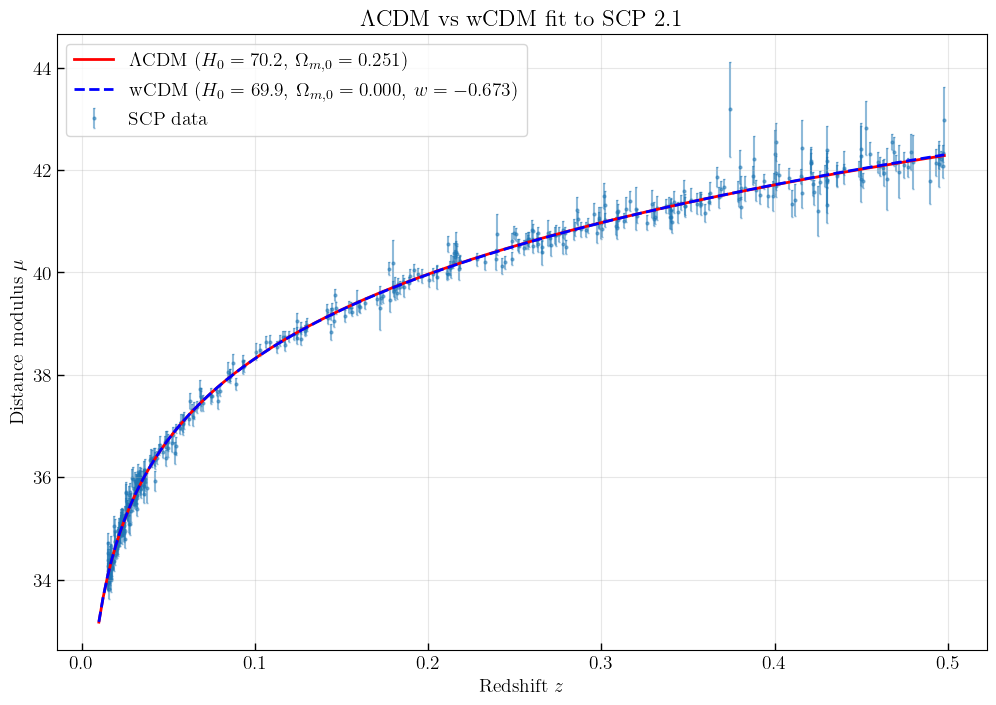

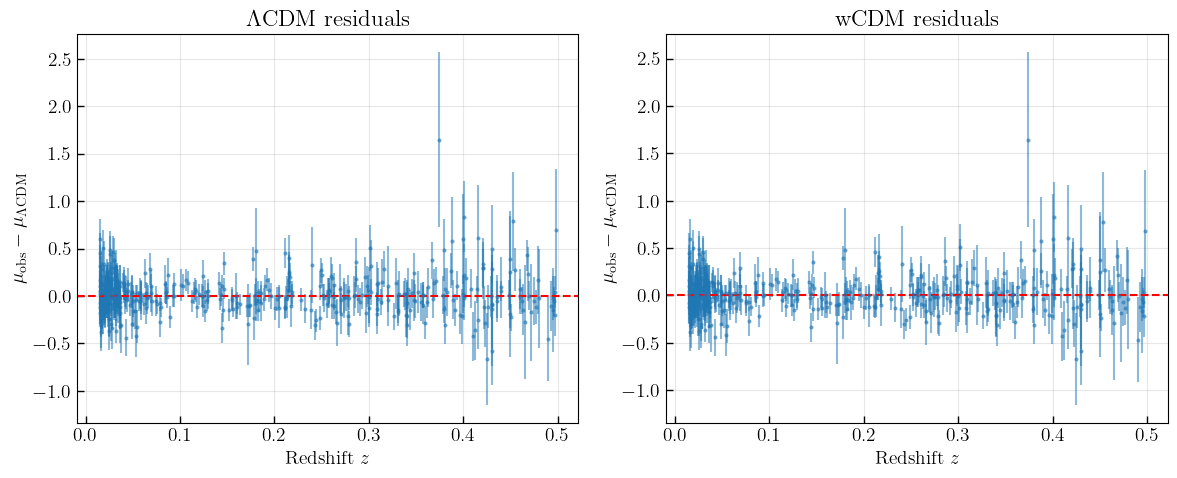

In [121]:
H0_lcdm, Om_lcdm       = theta_lcdm
H0_wcdm, Om_wcdm, w_mle = theta_wcdm

# --- model curves on a dense z grid ---
z_plot = np.linspace(0.01, np.max(z_data), 200)

mu_lcdm_plot = mu_model(theta_lcdm, z_plot, model="LCDM")
mu_wcdm_plot = mu_model(theta_wcdm, z_plot, model="wCDM")

plt.figure(figsize=(12, 8))

# data
plt.errorbar(
    z_data, mu_data, yerr=mu_err_data,
    fmt='o', alpha=0.5, markersize=2, capsize=1,
    label='SCP data', zorder=1
)

# models
plt.plot(
    z_plot, mu_lcdm_plot, 'r-', linewidth=2,
    label=rf'$\Lambda$CDM ($H_0={H0_lcdm:.1f}$, $\Omega_{{m,0}}={Om_lcdm:.3f}$)'
)
plt.plot(
    z_plot, mu_wcdm_plot, 'b--', linewidth=2,
    label=rf'wCDM ($H_0={H0_wcdm:.1f}$, $\Omega_{{m,0}}={Om_wcdm:.3f}$, $w={w_mle:.3f}$)'
)

plt.xlabel('Redshift $z$')
plt.ylabel('Distance modulus $\mu$')
plt.title(r'$\Lambda$CDM vs wCDM fit to SCP 2.1')
plt.legend()
plt.grid(alpha=0.3)
plt.yscale('linear')
plt.show()

# --- residuals ---
mu_lcdm_data = mu_model(theta_lcdm, z_data, model="LCDM")
mu_wcdm_data = mu_model(theta_wcdm, z_data, model="wCDM")

residuals_lcdm = mu_data - mu_lcdm_data
residuals_wcdm = mu_data - mu_wcdm_data

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.errorbar(
    z_data, residuals_lcdm, yerr=mu_err_data,
    fmt='o', alpha=0.5, markersize=2
)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Redshift $z$')
plt.ylabel(r'$\mu_{\rm obs} - \mu_{\Lambda{\rm CDM}}$')
plt.title(r'$\Lambda$CDM residuals')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.errorbar(
    z_data, residuals_wcdm, yerr=mu_err_data,
    fmt='o', alpha=0.5, markersize=2
)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Redshift $z$')
plt.ylabel(r'$\mu_{\rm obs} - \mu_{\rm wCDM}$')
plt.title('wCDM residuals')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


You must install the tqdm library to use progress indicators with emcee


POSTERIOR FOR Omega_m0 IN lCDM
MCMC parameters: 32 walkers, 3000 steps, 1000 burn-in
Running MCMC for lCDM posterior...
Posterior for Omega_m0:
Median: 0.2629
68% CI: [0.2400, 0.2866]


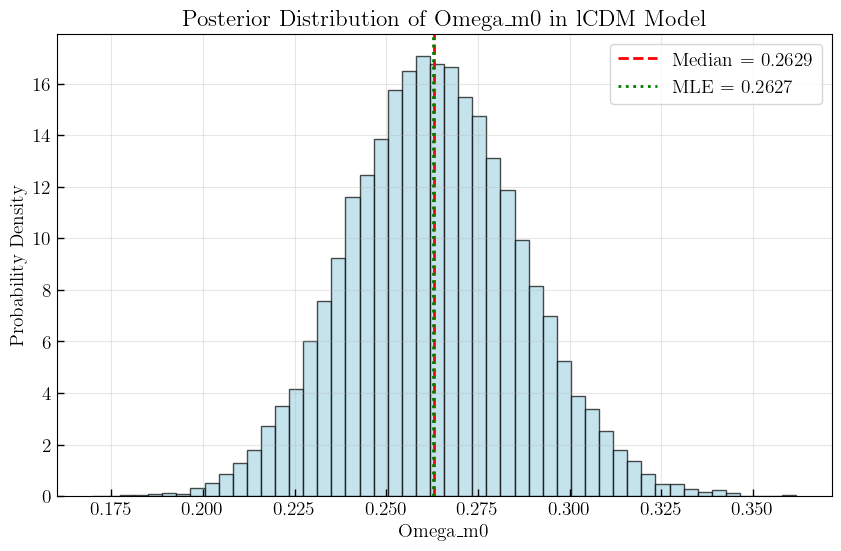

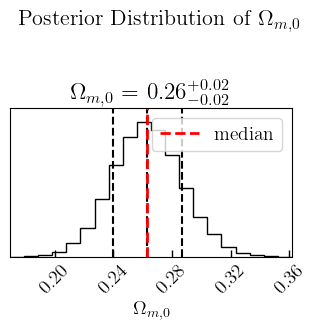

In [123]:
# MCMC for lCDM posterior distribution
print("POSTERIOR FOR Omega_m0 IN lCDM")


def log_posterior_lcdm(params, z_data, mu_data, mu_err_data):
    """
    Posterior for lCDM with uniform prior on Ω_m0
    """
    Omega_m0 = params[0]
    
    # Uniform prior: omega_m0  - U(0, 1)
    if not (0 <= Omega_m0 <= 1):
        return -np.inf
    
    # Likelihood 
    return log_likelihood_lcdm(params, z_data, mu_data, mu_err_data)

# MCMC setup
nwalkers = 32
ndim = 1  # Only Ω_m0
nsteps = 3000
burnin = 1000

print(f"MCMC parameters: {nwalkers} walkers, {nsteps} steps, {burnin} burn-in")

# Initialize walkers around MLE
initial_pos = np.array([Omega_m0_mle_lcdm]) + 0.01 * np.random.randn(nwalkers, ndim)

# Initialize sampler
sampler_lcdm = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior_lcdm,
    args=(z_data, mu_data, mu_err_data)
)

# Run MCMC
print("Running MCMC for lCDM posterior...")
sampler_lcdm.run_mcmc(initial_pos, nsteps, progress=True)

# Extract samples
samples_lcdm = sampler_lcdm.chain[:, burnin:, 0].reshape(-1)
Omega_m0_samples = samples_lcdm

# Calculate posterior summary
Omega_m0_median = np.median(Omega_m0_samples)
Omega_m0_low, Omega_m0_high = np.percentile(Omega_m0_samples, [16, 84])

print(f"Posterior for Omega_m0:")
print(f"Median: {Omega_m0_median:.4f}")
print(f"68% CI: [{Omega_m0_low:.4f}, {Omega_m0_high:.4f}]")

# Plot posterior distribution
plt.figure(figsize=(10, 6))
plt.hist(Omega_m0_samples, bins=50, density=True, alpha=0.7, 
         color='lightblue', edgecolor='black')
plt.axvline(Omega_m0_median, color='red', linestyle='--', linewidth=2,
           label=f'Median = {Omega_m0_median:.4f}')
plt.axvline(Omega_m0_mle_lcdm, color='green', linestyle=':', linewidth=2,
           label=f'MLE = {Omega_m0_mle_lcdm:.4f}')
plt.xlabel('Omega_m0')
plt.ylabel('Probability Density')
plt.title('Posterior Distribution of Omega_m0 in lCDM Model')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Corner plot (1D)
fig = corner.corner(
    Omega_m0_samples.reshape(-1, 1),
    labels=[r'$\Omega_{m,0}$'],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True
)

# Overplot the median as a vertical line on the 1D axis
ax = fig.axes[0]          # only one dimension → only one axis
ax.axvline(Omega_m0_median, color='red', ls='--', lw=2, label='median')
ax.legend()

fig.suptitle('Posterior Distribution of $\\Omega_{m,0}$', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Posterior for Omega_m0:
 Median: 0.2629
MLE: 0.2627
 8% Confidence Interval: [0.2400, 0.2866]
Standard deviation: 0.0236


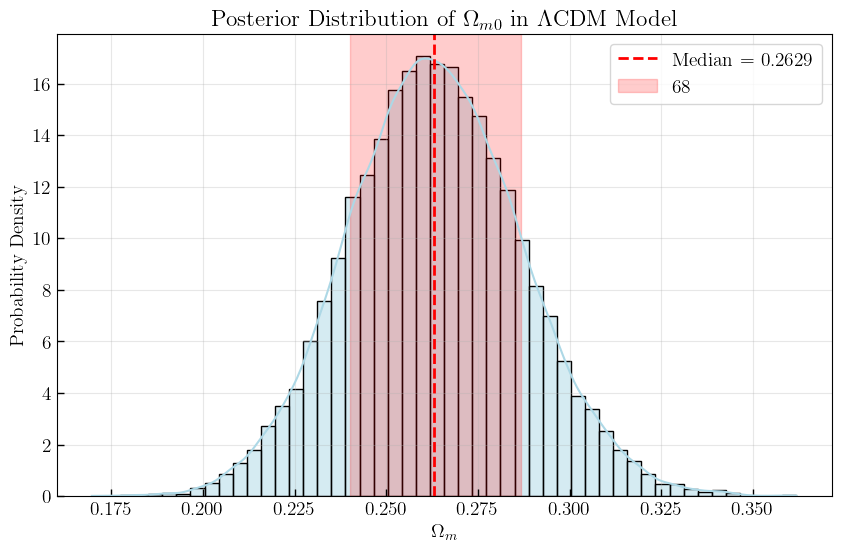

In [135]:
print(f"Posterior for Omega_m0:")
print(f" Median: {Omega_m0_median:.4f}")
print(f"MLE: {Omega_m0_mle_lcdm:.4f}")
print(f" 8% Confidence Interval: [{Omega_m0_low:.4f}, {Omega_m0_high:.4f}]")
print(f"Standard deviation: {np.std(Omega_m0_samples):.4f}")
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(Omega_m0_samples, bins=50, kde=True, stat='density', 
             color='lightblue', edgecolor='black')

plt.axvline(Omega_m0_median, color='red', linestyle='--', linewidth=2,
           label=f'Median = {Omega_m0_median:.4f}')
plt.axvspan(Omega_m0_low, Omega_m0_high, alpha=0.2, color='red',
           label=f'68% CI: [{Omega_m0_low:.4f}, {Omega_m0_high:.4f}]')

plt.xlabel(f'$\Omega_m$')
plt.ylabel('Probability Density')
plt.title(f'Posterior Distribution of $\Omega$$_m$$_0$ in $\Lambda$CDM Model')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()